# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from scipy.spatial import procrustes

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)


%run "_dataset-selection.ipynb"


# procrustes comparison

## 2 monkeys, same epoch

load the data

In [10]:
full_list_MCx = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_MCx.append((animal,sessionList))
full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
# load the DFs
warnings.filterwarnings("ignore")
allDFs_MCx = []
for animal, session in full_list_MCx:
    path = root/animal/session
    allDFs_MCx.append(defs.prep_general(dt.load_pyal_data(path)))


warnings.filterwarnings("default")


pairFileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        pairFileList1.append((I,J))

print(f'{len(pairFileList1)=}')

len(pairFileList1)=126


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

min_trials=15
min_time=15


Text(0.5, 0, 'sessions')

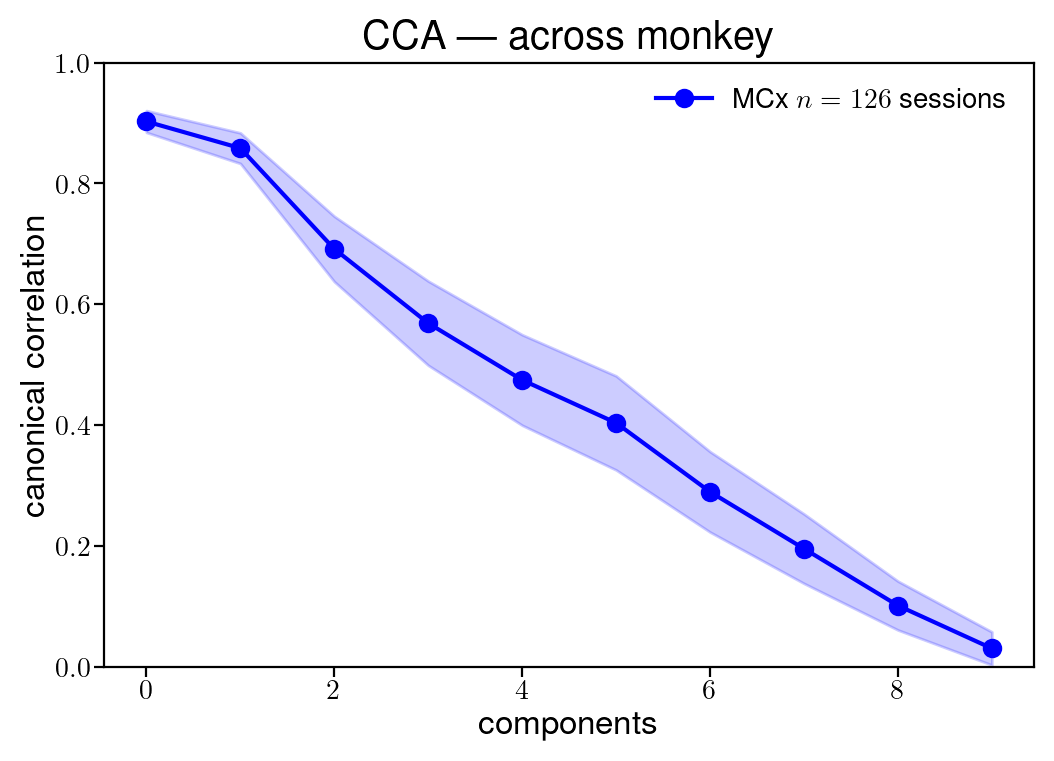

In [5]:
side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
side2df = [allDFs_MCx[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

warnings.filterwarnings("default")

allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allCCs0.append(dt.canoncorr(data1, data2))
allCCs0 = np.array(allCCs0).T

# plot
_,ax = plt.subplots(dpi=100)
utility.shaded_errorbar(ax, allCCs0, color='b', marker = 'o', label=f'{defs.areas[2]} $n={allCCs0.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('components')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- across monkey', usetex=True);

_,ax = plt.subplots(ncols=1, figsize=(10,5))
ax.plot(allCCs0[:4,:].mean(axis=0),'.')
ax.set_ylabel('average canonical correlation')
ax.set_title(f'CCA --- across monkey {defs.areas[2]} ', usetex=True);
ax.set_ylim([0,1])
ax.set_xlabel('sessions')
